<Axes: xlabel='timestamp'>

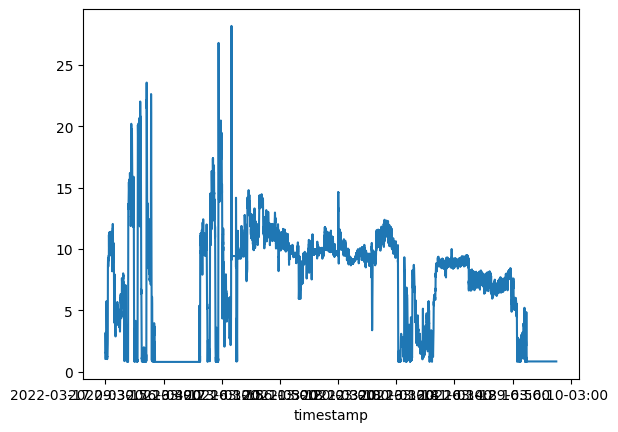

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

df = pd.read_csv('../../2022/boat_data_1s.csv')
df = df.set_index('timestamp')

# Filter
df['gps_speed'] = df['gps_speed'].rolling(10, center=True).mean()
df = df[(df['gps_speed'] > 0.8) & (df['gps_speed'] < 30)]
df = df.dropna()

df.columns

df['gps_speed'].plot()

In [5]:
df.columns

Index(['Unnamed: 0', 'batt_io', 'batt_po', 'batt_v', 'bat1_v', 'bat2_v', 'bat3_v',
       'boat_on', 'dms_on', 'esc_dt', 'esc_vi', 'mcb_po', 'mcb1_dt', 'mcb1_io',
       'mcb1_po', 'mcb1_vi', 'mcb1_vo', 'mcb2_dt', 'mcb2_io', 'mcb2_po',
       'mcb2_vi', 'mcb2_vo', 'motor_on', 'motor_rpm', 'mppt_i_out', 'mppt_p_in',
       'mppt_p_out', 'mppt_v_out', 'mppt1_dt', 'mppt1_ii', 'mppt1_pi', 'mppt1_vi',
       'mppt1_vo', 'mppt2_dt', 'mppt2_ii', 'mppt2_pi', 'mppt2_vi', 'mppt2_vo',
       'mppt3_dt', 'mppt3_ii', 'mppt3_pi', 'mppt3_vi', 'mppt3_vo', 'mppt4_dt',
       'mppt4_ii', 'mppt4_pi', 'mppt4_vi', 'mppt4_vo', 'prop_rpm',
       'solcast_AirTemp', 'solcast_energy', 'solcast_poa', 'trans_rpmi',
       'trans_rpmo', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_speed', 'gps_heading', 'gps_distance', 'gps_timestamp'],
      dtype='object')

array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

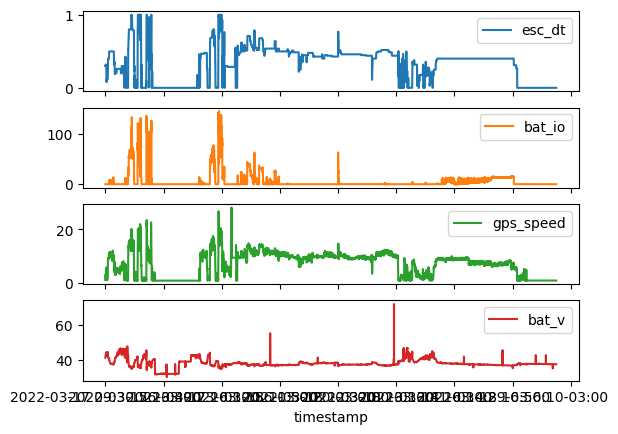

In [13]:
df[['esc_dt', 'batt_io', 'gps_speed', 'batt_v']].plot(subplots=True)

In [3]:
import numpy as np
import pandas as pd

# bin pilot_d into small bins (e.g. 0.01)
bins = np.linspace(0, 1, 51)     # 0 to 1 in 0.02 steps
df['pilot_bin'] = pd.cut(df['esc_dt'], bins=bins, labels=False, include_lowest=True)

# compute mean steady hull_u for each bin (remove accel phases)
grouped = df.groupby('pilot_bin').agg(
    pilot_d_mean=('esc_dt', 'mean'),
    hull_u_mean=('gps_speed', 'median'),
    hull_u_std=('gps_speed', 'std'),
    count=('gps_speed', 'size')
)

# filter bins with enough data
grouped = grouped[grouped['count'] > 50]
grouped


,pilot_d_mean,hull_u_mean,hull_u_std,count
pilot_bin,,,,
0,0.000187,0.839032,1.002743,4787
3,0.068416,1.439549,1.081003,85
4,0.092502,2.120250,0.937627,71
5,0.114620,2.342051,1.622804,98
7,0.150783,2.108933,1.215098,70
8,0.172320,2.929310,1.191208,377
9,0.198477,4.341871,1.144878,128
11,0.232623,5.046465,1.731865,111
12,0.254940,5.118722,1.091690,332


In [4]:
coeff = np.polyfit(grouped['pilot_d_mean'], grouped['hull_u_mean'], deg=3)
poly = np.poly1d(coeff)
poly

poly1d([-1.33360827, -0.35767604, 20.88382137,  0.03867145])

[0.54340307]


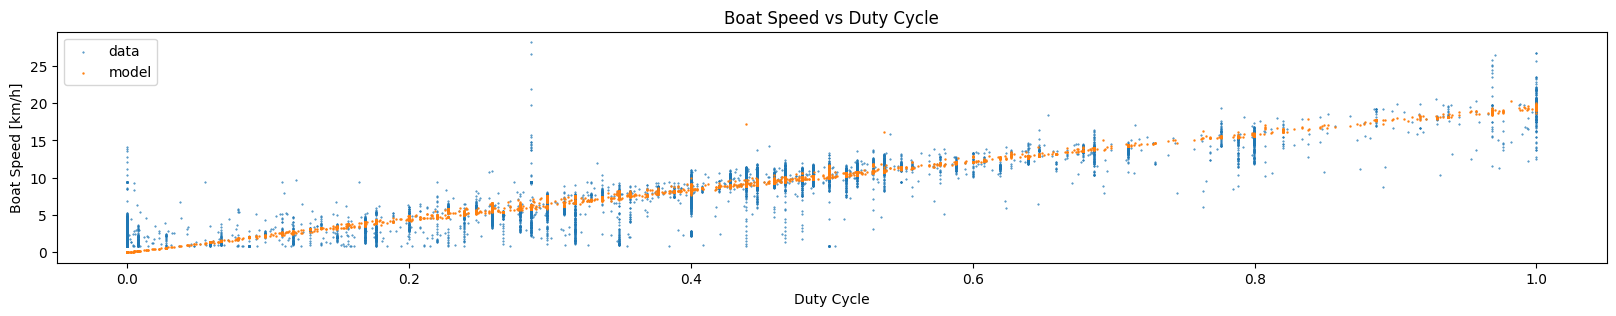

In [ ]:
def boat_speed_from_motor_v(motor_v, a=0.54340307):
    return a*motor_v

motor_v = df['batt_v'] * df['esc_dt']

popt, _ = curve_fit(boat_speed_from_motor_v, motor_v.to_numpy(), df["gps_speed"].to_numpy())
print(popt)

speed_hat = boat_speed_from_motor_v(motor_v.to_numpy(), *popt)

plt.figure(figsize=(20,3))
plt.scatter(df['esc_dt'], df['gps_speed'], label='data', s=0.2)
plt.scatter(df['esc_dt'], speed_hat, label='model', s=0.5)
plt.ylabel("Boat Speed [km/h]")
plt.xlabel("Duty Cycle")
plt.title("Boat Speed vs Duty Cycle")
plt.legend()
plt.show()